In [14]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import logger
import xesmf as xe
from scipy.ndimage import label

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask

import climtas.nci
from dask.distributed import Client, as_completed

In [3]:
LOG = logger.get_logger(__name__)

In [4]:
ds_mean = xr.open_dataset('/g/data/er8/users/cd3022/solar_drought/himawari_irradiance_means/total_mean.nc')

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [8]:
def drought_metrics(date, var):

    date_dt = datetime.strptime(date, "%m-%Y")
    year = date_dt.strftime("%Y")
    month = date_dt.strftime("%m")
    
    ##### Himawari Data
    if date_dt <= datetime.strptime('2019-03-31', '%Y-%m-%d'):
        version = 'v1.0'
    else:
        version = 'v1.1'
    directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/{version}/{year}/{month}')
    files = sorted(str(p) for p in directory.rglob("*.nc"))
    def _preprocess(ds):
        return ds.drop_vars(set(ds.data_vars) - {'daily_integral_of_surface_global_irradiance'})
    
    himawari = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=_preprocess,
        # engine='netcdf4',
    )
    LOG.info('OPEN HIMAWARI')
    himawari = himawari.chunk({'time':-1})

    threshold = 0.5
    data = himawari.daily_integral_of_surface_global_irradiance
    mean = ds_mean.daily_integral_of_surface_global_irradiance
    droughts = data < (threshold * mean)

    _MAX_EVENTS = 100 # so the compute_durations function outputs arrays of equal length
    # Get drought lengths
    def compute_durations(da):
        labels, num = label(da)
        durations = np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)
        padded = np.full((_MAX_EVENTS,), fill_value=np.nan, dtype=np.float32)
        padded[:len(durations)] = durations[:_MAX_EVENTS]
        return padded

    # creates an array of "drought" durations
    durations = xr.apply_ufunc(
        compute_durations,
        droughts,
        input_core_dims=[['time']],
        output_core_dims=[['event']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32],
        output_sizes={'event': _MAX_EVENTS},  # this fixes the ValueError
    )
    
    # events normally defined using duration >= 3, but this may not be appropriate for solar
    # see https://climpact-sci.org/indices/ for more details
    if var == 'HWA':
        return data.min(dim='time')
        
    if var == 'HWD':
        return durations.max(dim='event', skipna=True)

    if var == 'HWF':
        return droughts.sum(dim='time')
        
    if var == 'HWN': 
        return xr.where(durations > 0, 1, 0).sum()

    if var == 'HWM':
        drought_data = xr.where(data < (threshold * mean), data, np.nan)
        return drought_data.mean(dim='time', skipna=True)

In [86]:
# Step 1: Create binary mask
data = [0,1,1,1,1,0,1,1,0,1,0,0,0,1,1,1, 0, 1, 0, 1, 0, 1, 1, 1]
time= np.linspace(1,len(data), len(data))
my_da = xr.DataArray(data, coords={'time':time})

# Step 2: Function to compute durations along 1D time axis
def compute_durations(mask_1d):
    labels, num = label(mask_1d)
    return np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)

# Step 3: Apply function along 'time' axis using apply_ufunc
durations = xr.apply_ufunc(
    compute_durations,
    my_da,
    input_core_dims=[['time']],
    output_core_dims=[['event']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.int32],
)

In [9]:
client = Client(
    n_workers=6,
    threads_per_worker=1
)
client

2025-06-06 13:16:38,316:py.warnings:WARNING: /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42249 instead
  warnings.warn(

Perhaps you already have a cluster running?
Hosting the HTTP server on port 42249 instead
  warnings.warn(



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42249/status,
Dashboard: /proxy/42249/status,Workers: 6
Total threads: 6,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41559,Workers: 6
Dashboard: /proxy/42249/status,Total threads: 6
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:36361,Total threads: 1
Dashboard: /proxy/34735/status,Memory: 15.83 GiB
Nanny: tcp://127.0.0.1:46203,


In [17]:
var = 'HWF'

if __name__ == '__main__':
    futures = {}
    total = []
    for year in range(2016, 2025):
        for month in range(1,4):
            date = f'{month}-{year}'
            future = client.submit(drought_metrics, date, var)
            futures[future] = date
    
        seasonal_results = []
        labels = []
        for future in as_completed(futures):
            result = future.result()
            seasonal_results.append(result)
            labels.append(futures[future])

        combined_season = xr.concat(seasonal_results, dim='date')
        # combined_season = combined_season.assign_coords(date=labels)

        season_total = combined_season.sum(dim='date', skipna=True)
        total.append(season_total)

    combined_total = xr.concat(total, dim='year')
    metric = combined_total.mean(dim='year', skipna=True)

2025-06-06 13:47:32,396:py.warnings:WARNING: /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 29.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

INFO:__main__:OPEN HIMAWARI
/jobfs/142467477.gadi-pbs/ipykernel_3049890/2998777196.py:41: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
2025-06-06 13:47:33,735:py.warnings:WARNING: /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 29.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

This may cause some slo

2025-06-06 13:48:11,539:py.warnings:WARNING: /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(



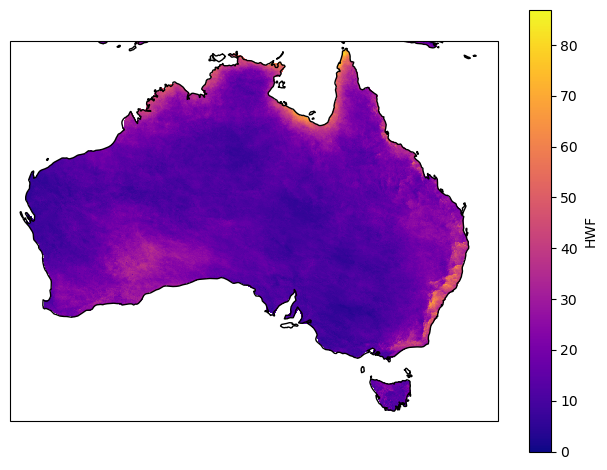

In [18]:
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(metric)
data_landonly = metric.where(land_mask == 0)

latitudes = metric.latitude
longitudes = metric.longitude
data = data_landonly.values

# Create a figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(longitudes, latitudes, data, cmap='plasma',vmin=0,  transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax)
# cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label(f'{var}') 
 
plt.tight_layout()

plt.show()